# Results for updated model with R0=1.2

In [1]:
# %load_ext autotime

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import glob
import pylab as plt
import json
import matplotlib as mpl
import os
import seaborn as sns
import warnings

from covid19_abm.dir_manager import get_data_dir

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

# District name, id, and metadata 

In [4]:
old_new_dist = pd.read_csv(
    get_data_dir('raw', 'district_relation.csv'), index_col=0)
old_new_dist_map = old_new_dist[['DIST2012', 'NEW_DIST_ID_2']].set_index('DIST2012').to_dict()['NEW_DIST_ID_2']
pop_dense = pd.read_csv(
    get_data_dir('raw', 'district_pop_dens_friction.csv'))
old_new_dist = old_new_dist.merge(pop_dense, on='DIST2012')

old_new_dist.head(10)

,CNTRY_NAME_x,ADMIN_NAME_x,CNTRY_CODE_x,IPUM2012_x,DIST2012,PARENT_x,NEW_DIST_ID_2,CNTRY_NAME_y,ADMIN_NAME_y,CNTRY_CODE_y,IPUM2012_y,PARENT_y,mean_pop_dens,total_pop,mean_friction_pop_weighted
0,Zimbabwe,Bulawayo Urban,716,21,21,0,1,Zimbabwe,Bulawayo Urban,716,21,0,1096.578765,629436.210860,0.002247
1,Zimbabwe,Buhera,716,1001,101,1,3,Zimbabwe,Buhera,716,1001,1,40.271155,266876.945520,0.009854
2,Zimbabwe,Chimanimani,716,1002,102,1,4,Zimbabwe,Chimanimani,716,1002,1,36.526321,151584.230765,0.015841
3,Zimbabwe,Chipinge Rural,716,1003,103,1,5,Zimbabwe,Chipinge Rural,716,1003,1,51.065586,332947.622011,0.012035
4,Zimbabwe,Makoni,716,1004,104,1,6,Zimbabwe,Makoni,716,1004,1,31.112857,299616.813787,0.010436
5,Zimbabwe,Mutasa,716,1006,106,1,8,Zimbabwe,Mutasa,716,1006,1,57.687771,179697.405791,0.014797
6,Zimbabwe,Nyanga,716,1007,107,1,9,Zimbabwe,Nyanga,716,1007,1,20.059747,142384.082603,0.014843
7,Zimbabwe,Mutare Rural,716,1005,105,1,7,Zimbabwe,Mutare Rural,716,1005,1,42.447097,288428.026434,0.011682
8,Zimbabwe,Bindura Rural,716,2001,201,2,10,Zimbabwe,Bindura Rural,716,2001,2,51.374755,140509.953851,0.009085
9,Zimbabwe,Muzarabani,716,2002,202,2,11,Zimbabwe,Muzarabani,716,2002,2,26.370214,136070.303745,0.011895


In [5]:
import geopandas as gpd

# p = gpd.read_file('../data/geo2_zw2012.shp')
shape = p = gpd.read_file(
    get_data_dir('raw', 'shapefiles', 'new_districts', 'ZWE_adm2.shp'))

In [6]:
shape['total_population'] = shape['ID_2'].map(old_new_dist.groupby('NEW_DIST_ID_2')['total_pop'].sum())

In [7]:
def load_model_logs_df(log_name):
    with open(log_name) as fl:
        content = fl.read()

    data = []
    prev_case = 0
    prev_hosp = 0
    prev_critical = 0

    for days, l in enumerate(content.strip().split('\n')):
        l = l.split(' $$ ')[-1]
        l = json.loads(l)

        total_infected = l['infected_count']
        total_hosp = l['hospitalized_count']
        total_critical = l['critical_count']

        current_case = total_infected - prev_case
        prev_case = total_infected

        current_hosp = total_hosp - prev_hosp
        prev_hosp = total_hosp

        current_critical = total_critical - prev_critical
        prev_critical = total_infected

        l['new_cases'] = current_case
        l['new_hospitalized'] = current_hosp
        l['new_critical'] = current_critical

        l['version'] = log_name
        l['days'] = days
        data.append(l)

    return pd.DataFrame(data)

In [8]:
R0 = 1.2
scale = 1

In [9]:
df = pd.DataFrame()

scenario_files = {
    'UnmitigatedScenario': 'Unmitigated',
#     'BlockGreatestMobilityScenario': 'Selective Blocking',
#     'LockdownGreatestMobilityScenario': 'Selective lockdown',
#     'OpenManufacturingAndSchoolsScenario': 'Continue lockdown - open manufacturing/schools',
#     'OpenSchoolsScenario': 'Continue lockdown - open schools',
#     'OpenSchoolsSeedKidsScenario': 'Continue lockdown - open schools, kids seed',
    'ContinuedLockdownScenario': 'Continue lockdown',
    'EasedLockdownScenario': 'Eased lockdown',
#     'HandWashingRiskScenario': 'Hand washing risk',
#     'SevereDiseaseRiskScenario': 'Severe disease risk',
#     'SevereDiseaseRiskImprovedScenario': 'Severe disease risk improved',
    'OpenSchoolsScenario': 'Continue lockdown - open schools',
    'EasedOpenSchoolsScenario': 'Eased lockdown - open schools',
}


for scenario in scenario_files:
    scenario_code = '_'.join(scenario.split('.')[0].split('_')[2:])
    scenario_code = scenario_files.get(scenario)
    scenario_df = pd.DataFrame()

    for fname in glob.glob(
        get_data_dir('logs', f'model_log_file_{scenario}*_R{R0}_*.log')):
        dump_file = fname.replace('model_log_', 'model_dump_').replace('.log', '.pickle')
        if not os.path.isfile(dump_file):
            continue

        d = load_model_logs_df(fname)
        d['scenario'] = scenario_code
        if scenario_df.empty:
            scenario_df = d
        else:
            scenario_df = pd.concat([scenario_df, d])

    if scenario_df.empty:
        print(scenario)
        continue
            
    scenario_df['date'] = pd.to_datetime(scenario_df['date'])
    max_date = scenario_df['date'].max()
    min_date = scenario_df['date'].min()

    full_dates = scenario_df[scenario_df['version'] == scenario_df[scenario_df['date'] == max_date].iloc[0].version]
    idx = full_dates['date']

    for v, gdf in scenario_df.groupby('version'):
        gdf = gdf.set_index('date')

        gdf = gdf.reindex(idx)
        gdf = gdf.fillna(method='ffill')
        gdf = gdf.reset_index()

        if df.empty:
            df = gdf
        else:
            df = pd.concat([df, gdf])

df['date'] = pd.to_datetime(df['date'])
ddf = df.copy()

In [10]:
df = ddf[ddf.date <= datetime(2021, 1, 1)]

# Sample daily data

In [11]:
df.head(10)

,date,current_contagious_count,infected_count,current_exposed_cases,current_contagious_cases,current_hospitalized_cases,current_critical_cases,asymptomatic_count,symptomatic_count,hospitalized_count,critical_count,died_count,recovered_count,new_cases,new_hospitalized,new_critical,version,days,scenario
0,2020-06-25 08:00:00,1,112,112,0,0,0,41,71,0,0,0,0,112,0,0,../logs/model_log_file_UnmitigatedScenario_00_...,0,Unmitigated
1,2020-06-26 08:00:00,10,112,103,9,0,0,41,71,0,0,0,0,0,0,-112,../logs/model_log_file_UnmitigatedScenario_00_...,1,Unmitigated
2,2020-06-27 08:00:00,26,114,95,19,0,0,42,72,0,0,0,0,2,0,-112,../logs/model_log_file_UnmitigatedScenario_00_...,2,Unmitigated
3,2020-06-28 08:00:00,52,122,77,45,0,0,44,78,0,0,0,0,8,0,-114,../logs/model_log_file_UnmitigatedScenario_00_...,3,Unmitigated
4,2020-06-29 08:00:00,78,139,65,73,0,0,53,86,0,0,0,1,17,0,-122,../logs/model_log_file_UnmitigatedScenario_00_...,4,Unmitigated
5,2020-06-30 08:00:00,94,160,69,88,0,0,63,97,0,0,0,3,21,0,-139,../logs/model_log_file_UnmitigatedScenario_00_...,5,Unmitigated
6,2020-07-01 08:00:00,108,185,79,101,0,0,73,112,0,0,0,6,25,0,-160,../logs/model_log_file_UnmitigatedScenario_00_...,6,Unmitigated
7,2020-07-02 08:00:00,128,209,84,113,0,0,83,126,1,0,0,14,24,1,-185,../logs/model_log_file_UnmitigatedScenario_00_...,7,Unmitigated
8,2020-07-03 08:00:00,148,238,98,119,2,0,94,144,2,0,0,23,29,1,-209,../logs/model_log_file_UnmitigatedScenario_00_...,8,Unmitigated
9,2020-07-04 08:00:00,170,264,97,136,2,0,107,157,2,0,0,33,26,0,-238,../logs/model_log_file_UnmitigatedScenario_00_...,9,Unmitigated


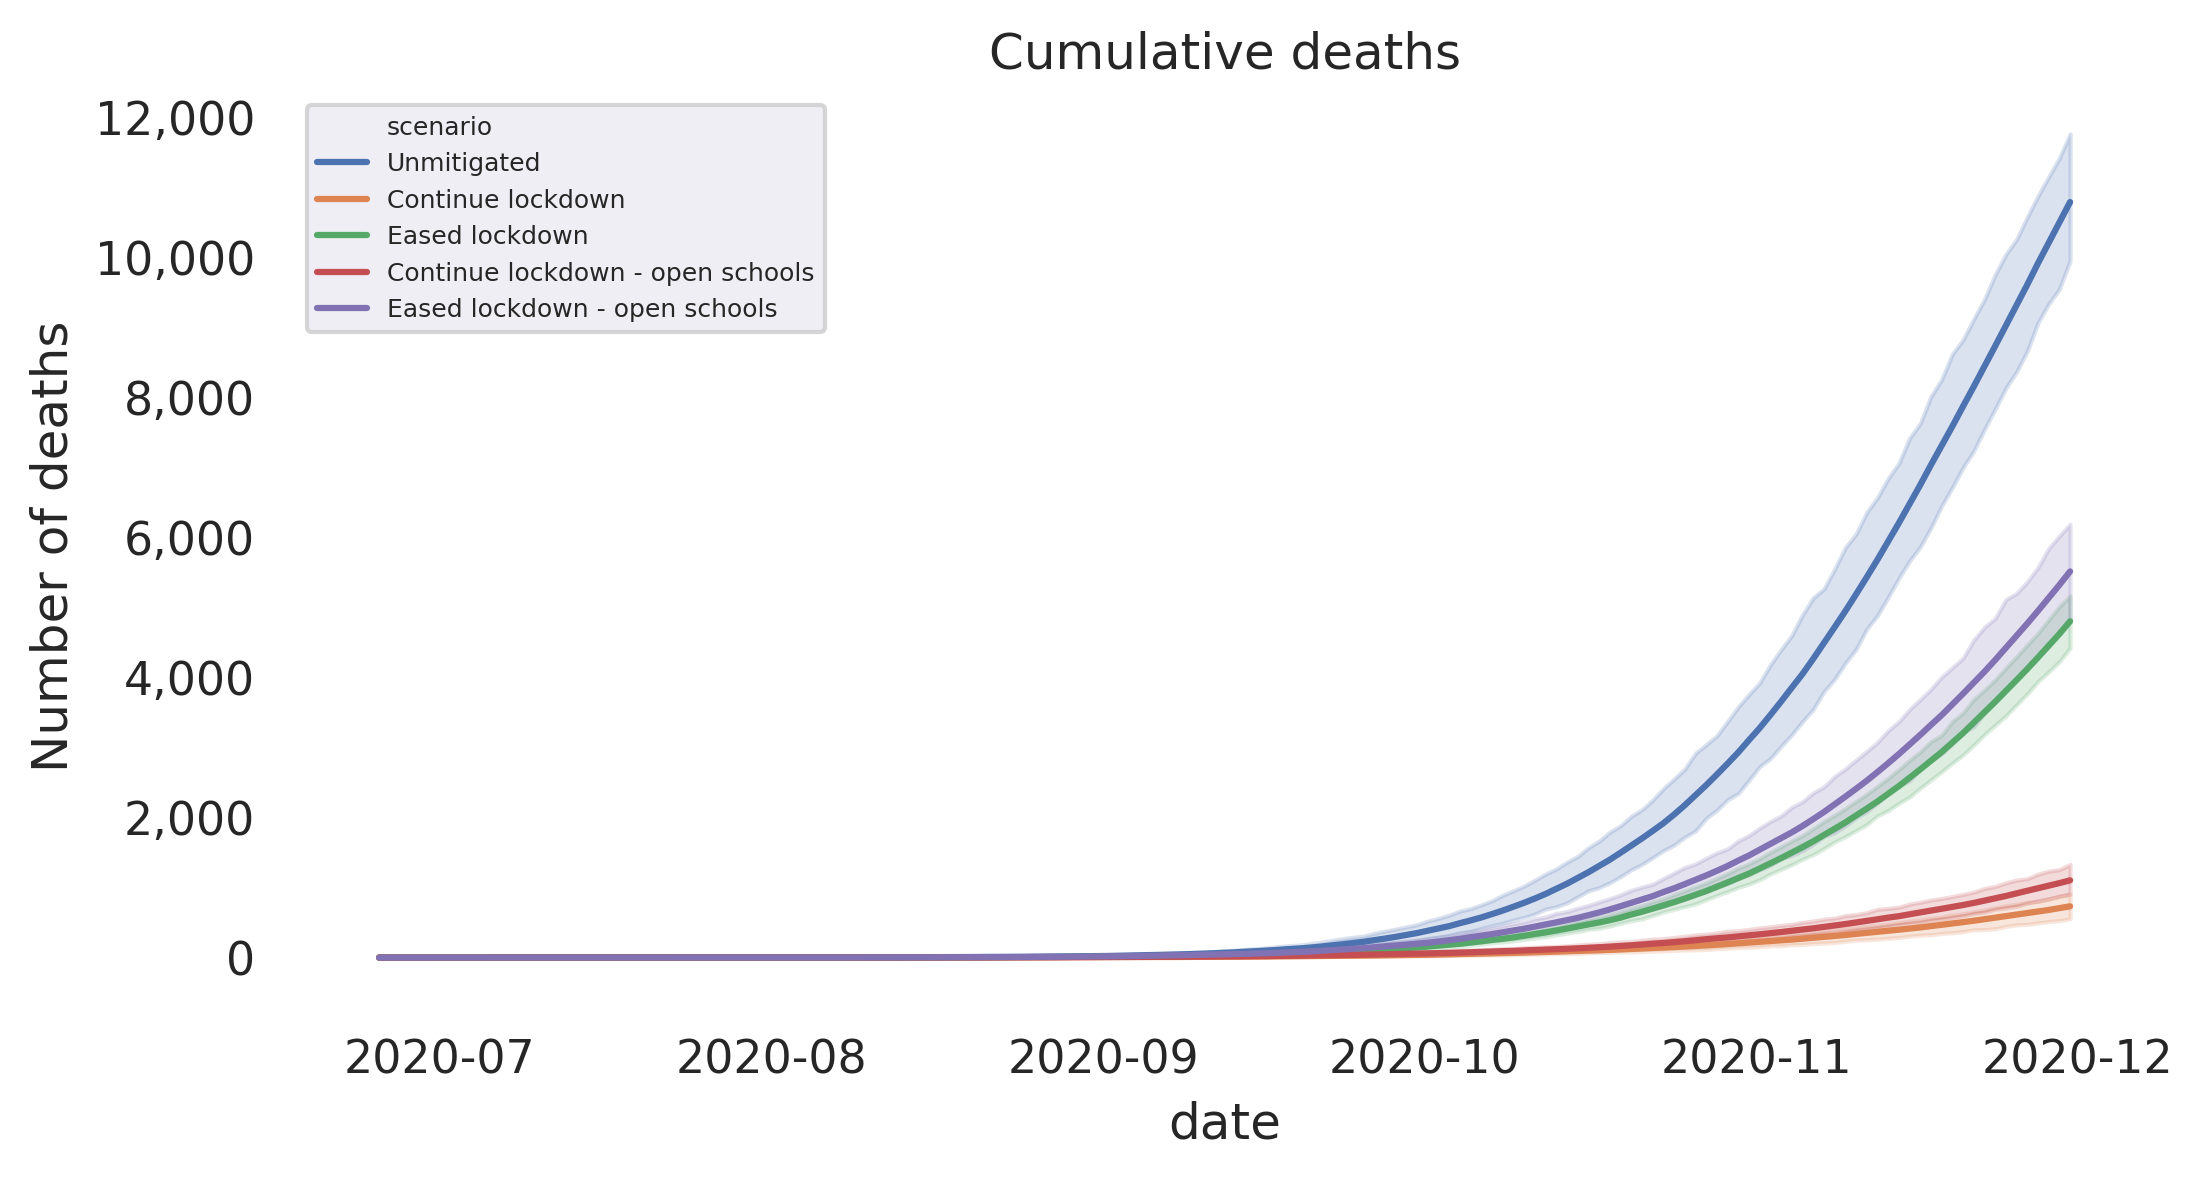

In [12]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Deaths'] = scale * df['died_count']

sns.lineplot(x="date", y="Deaths", hue='scenario',
             data=df, ax=ax)

ax.set_title('Cumulative deaths')
ax.set_ylabel('Number of deaths')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

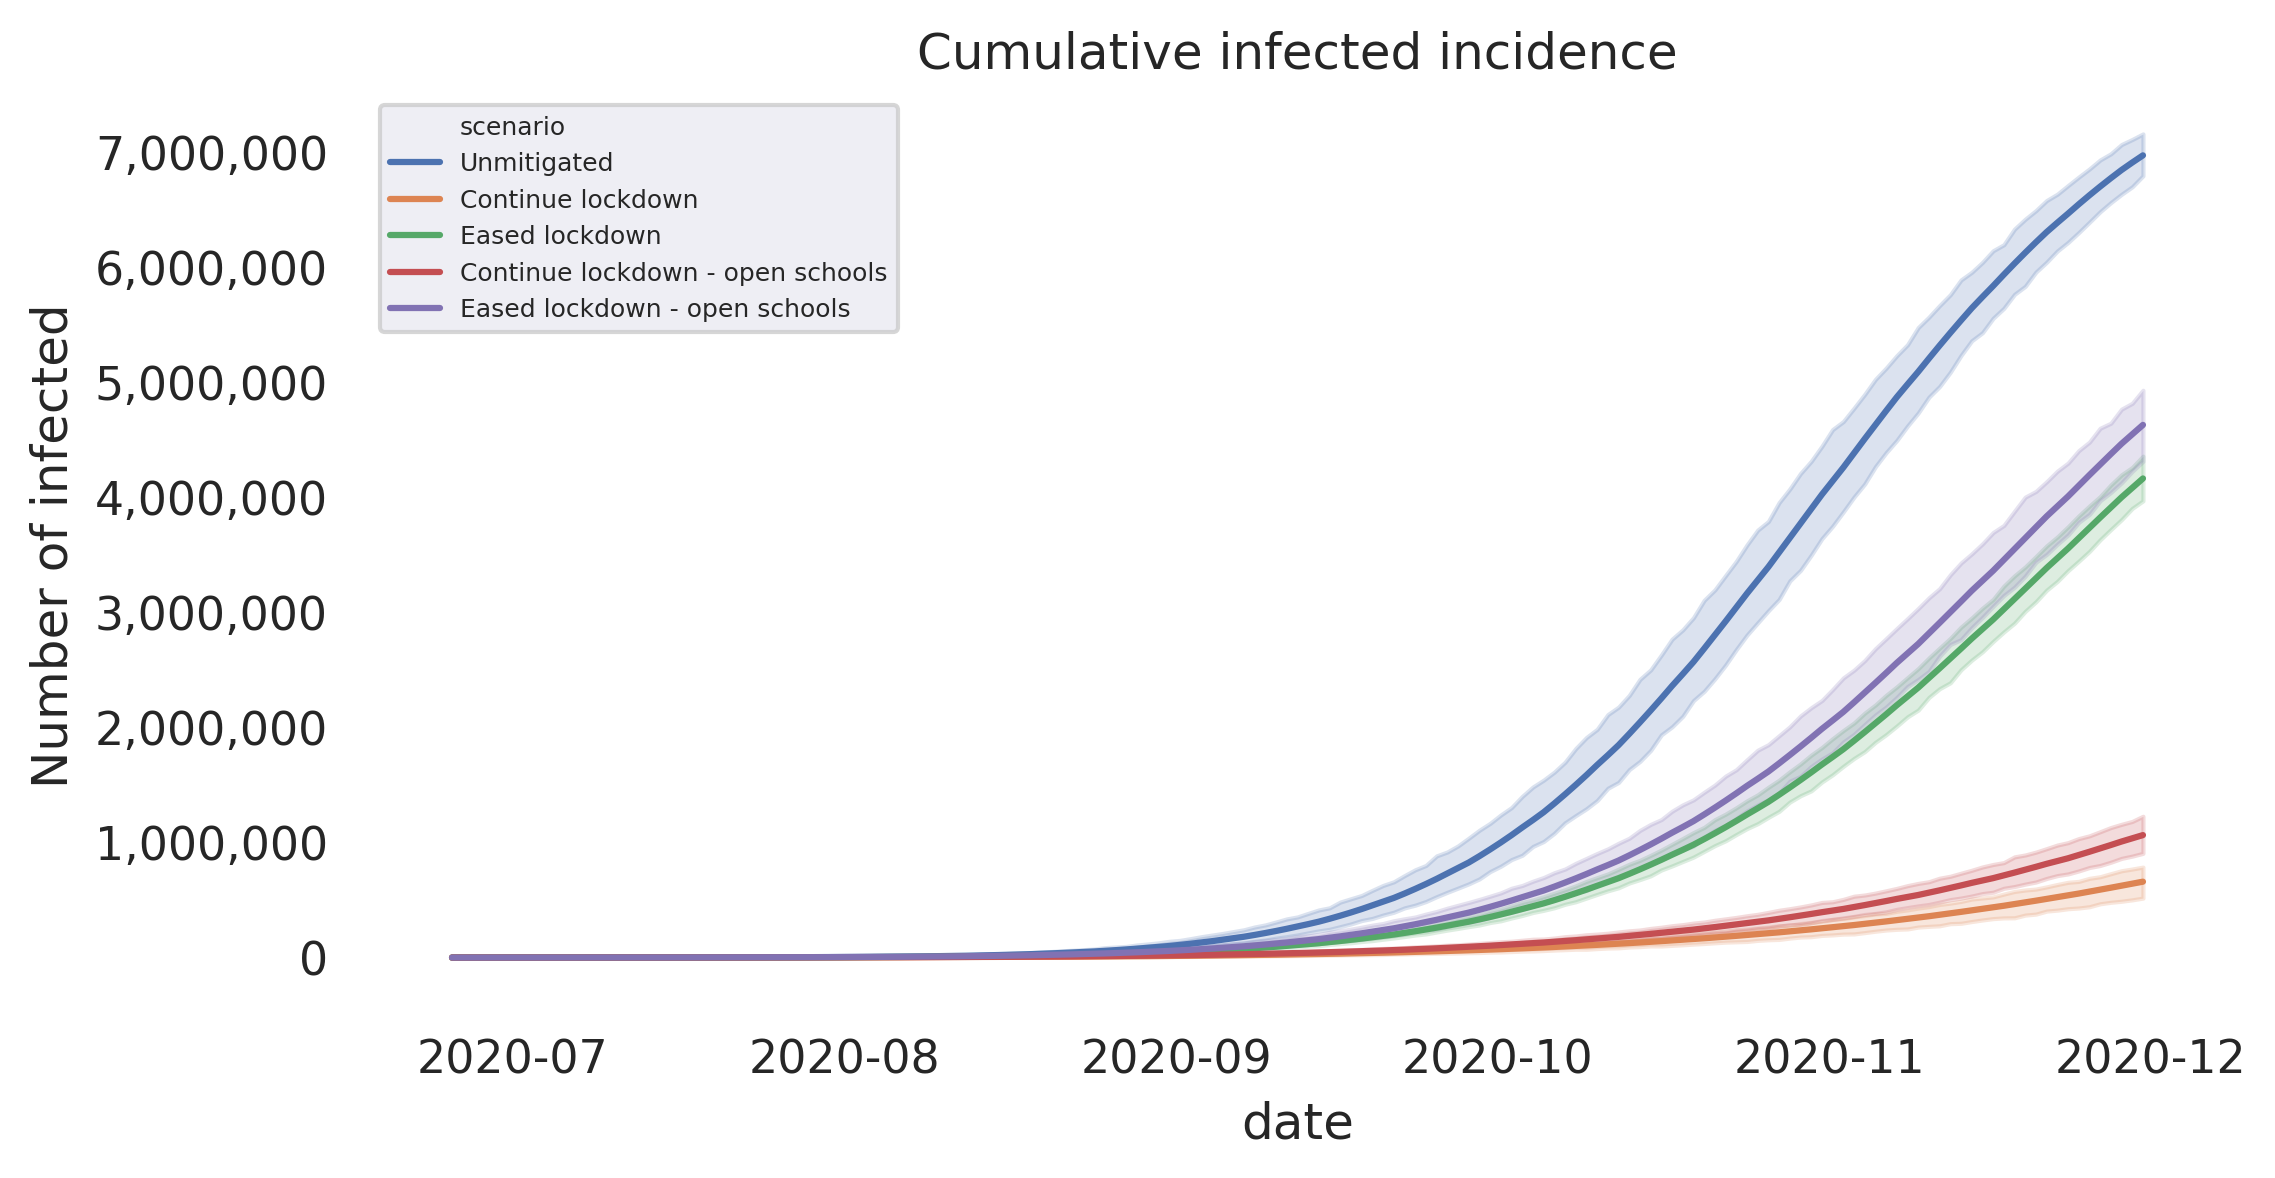

In [13]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Infected'] = scale * df['infected_count']

sns.lineplot(x="date", y="Infected", hue='scenario',
             data=df, ax=ax)

ax.set_title('Cumulative infected incidence')
ax.set_ylabel('Number of infected')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

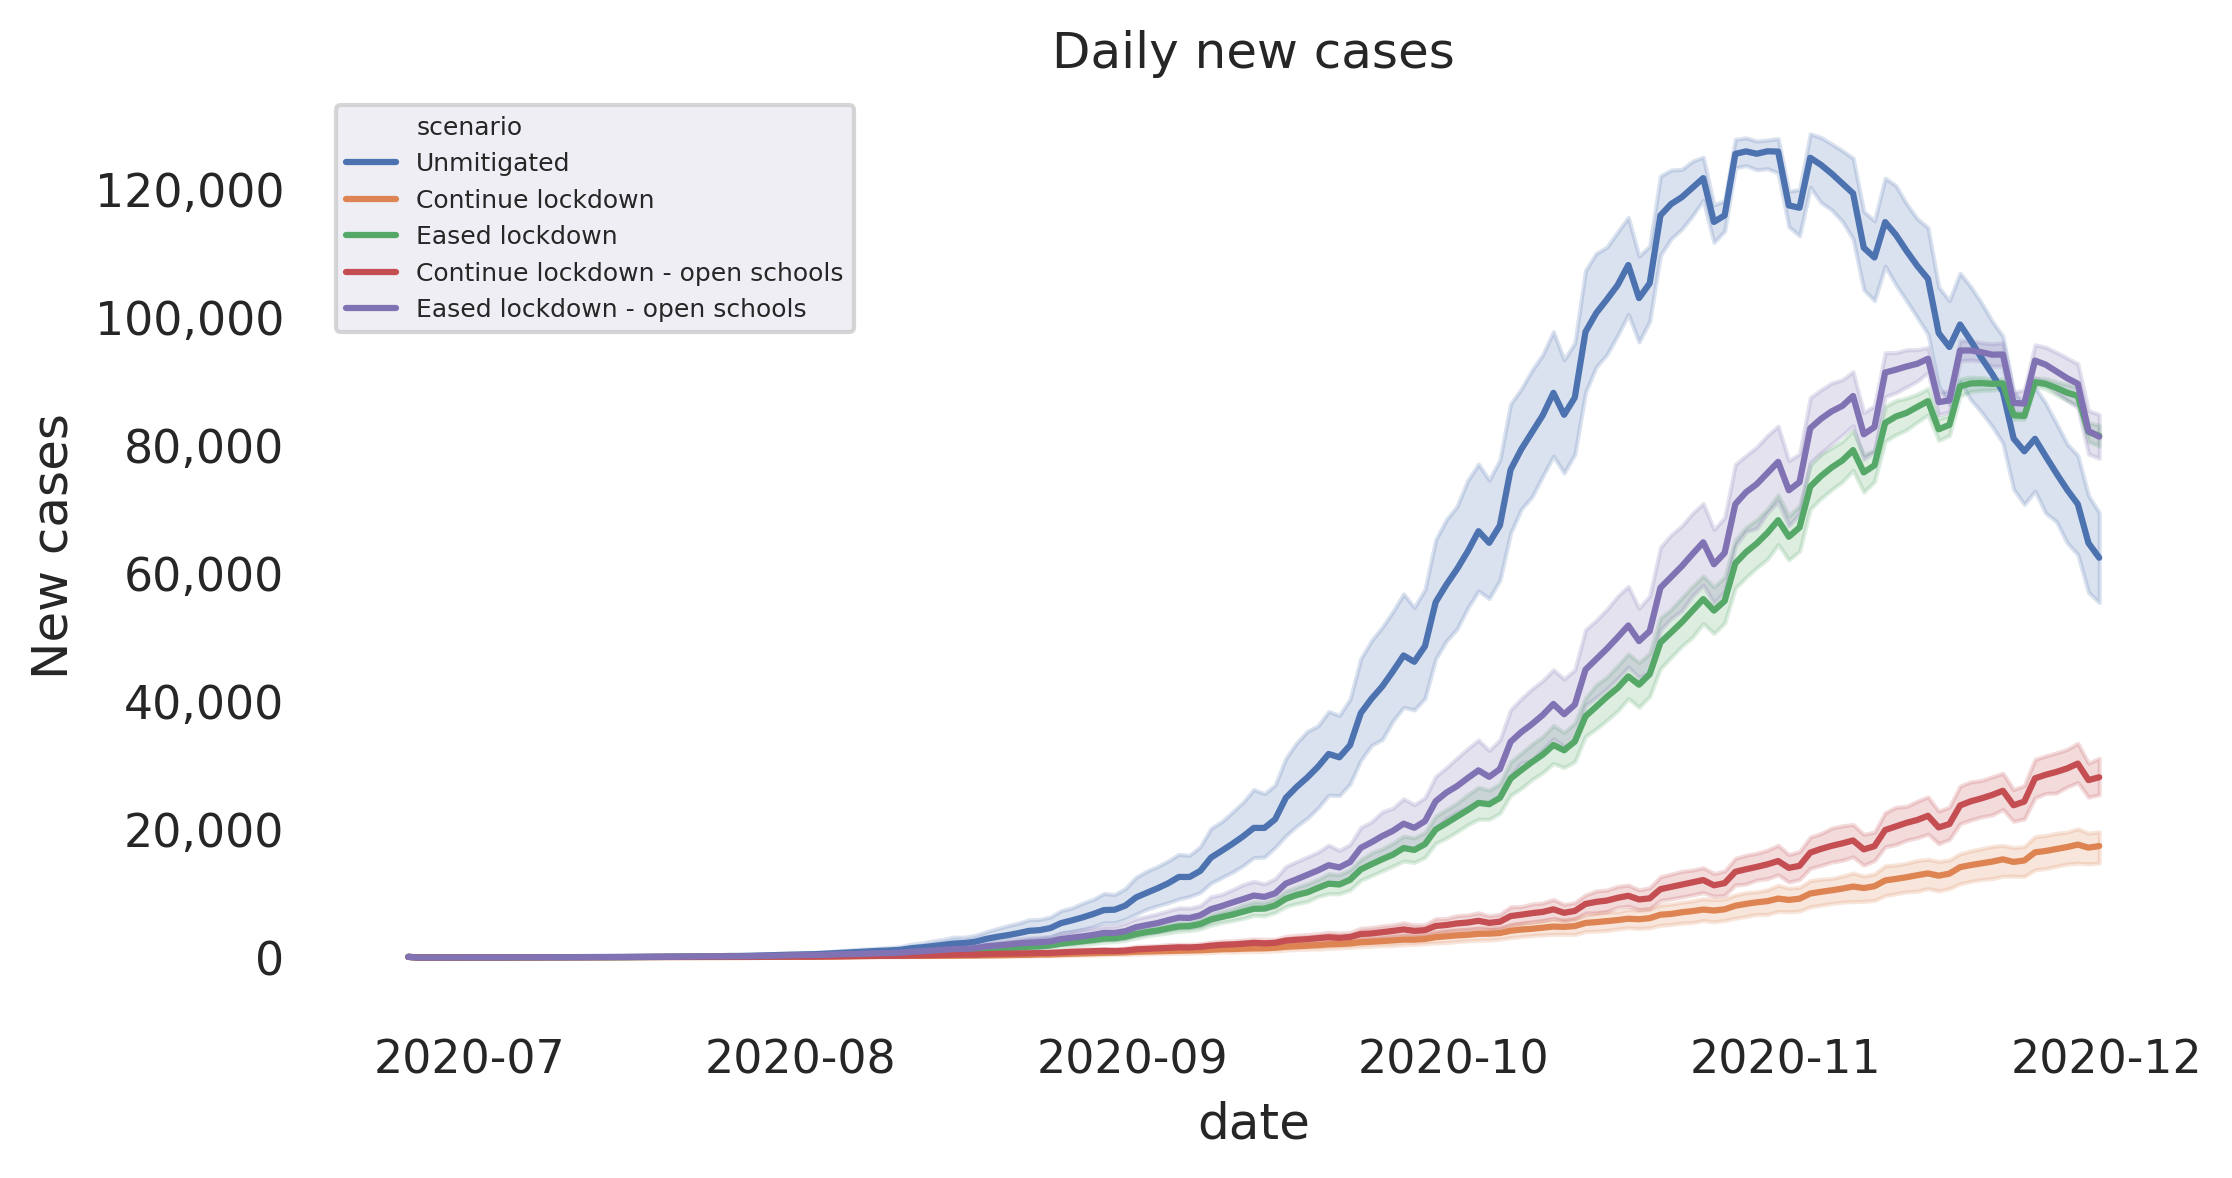

In [14]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['New cases'] = scale * df['new_cases']

sns.lineplot(x="date", y="New cases", hue='scenario',
             data=df, ax=ax)

ax.set_title('Daily new cases')
ax.set_ylabel('New cases')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

### Get max of daily new cases across scenarios

In [15]:
df.groupby(['scenario', 'date'])['New cases'].mean().groupby(level=['scenario']).max().astype(int)

scenario
Continue lockdown                    17647
Continue lockdown - open schools     30305
Eased lockdown                       89878
Eased lockdown - open schools        94845
Unmitigated                         125958
Name: New cases, dtype: int64

### Get date for max of daily new cases across scenarios

In [16]:
df.groupby(['scenario', 'date'])['New cases'].mean().groupby(level=['scenario']).apply(lambda x: x.idxmax())

scenario
Continue lockdown                            (Continue lockdown, 2020-11-28 08:00:00)
Continue lockdown - open schools    (Continue lockdown - open schools, 2020-11-28 ...
Eased lockdown                                  (Eased lockdown, 2020-11-24 08:00:00)
Eased lockdown - open schools       (Eased lockdown - open schools, 2020-11-17 08:...
Unmitigated                                        (Unmitigated, 2020-10-30 08:00:00)
Name: New cases, dtype: object

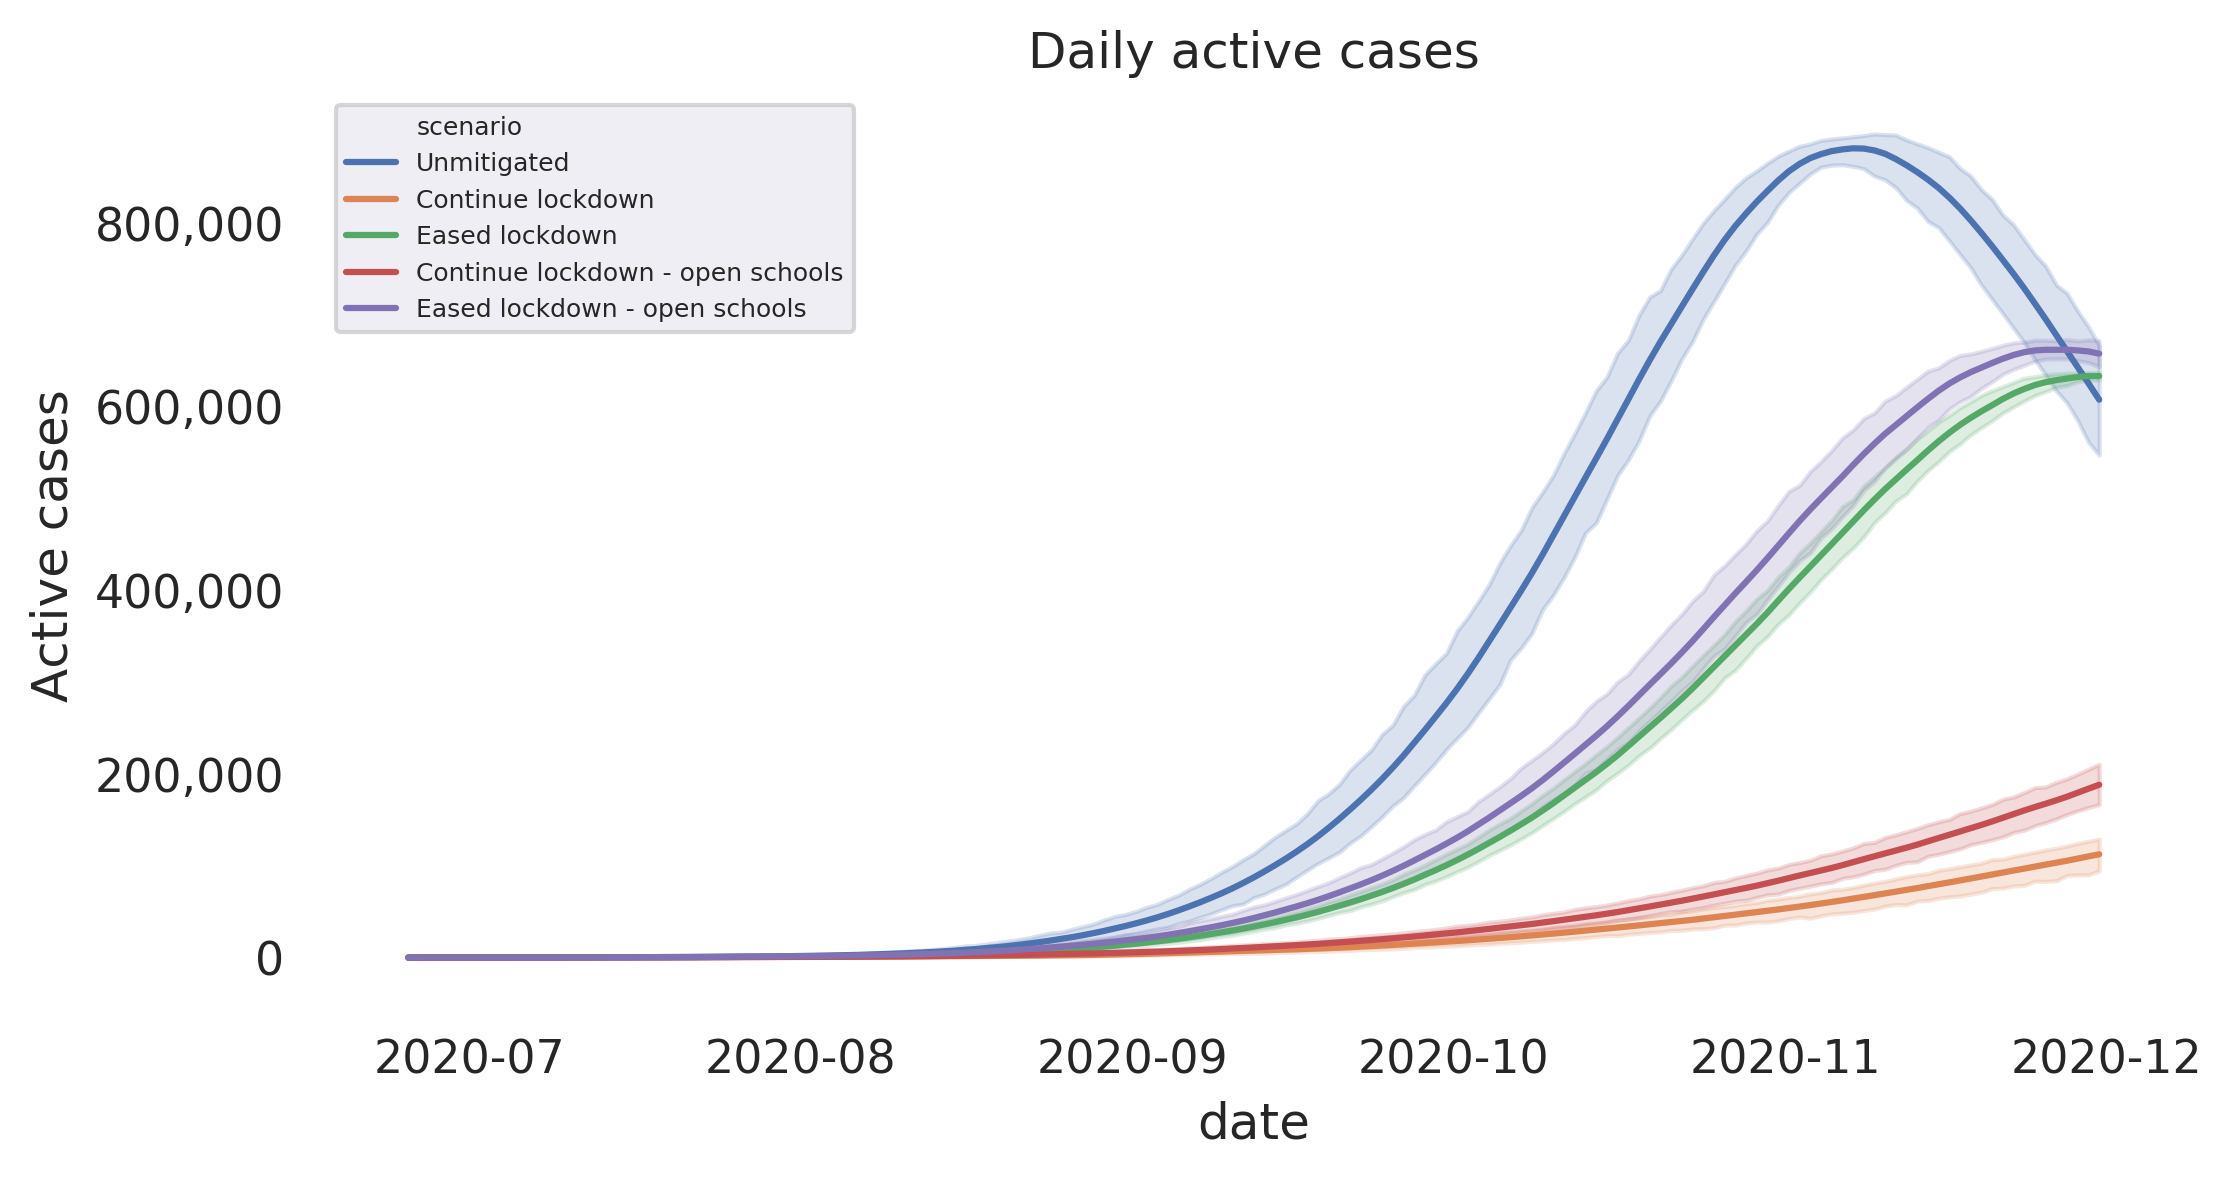

In [17]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Active cases'] = scale * df['current_contagious_cases']

sns.lineplot(x="date", y="Active cases", hue='scenario',
             data=df, ax=ax)

ax.set_title('Daily active cases')
ax.set_ylabel('Active cases')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

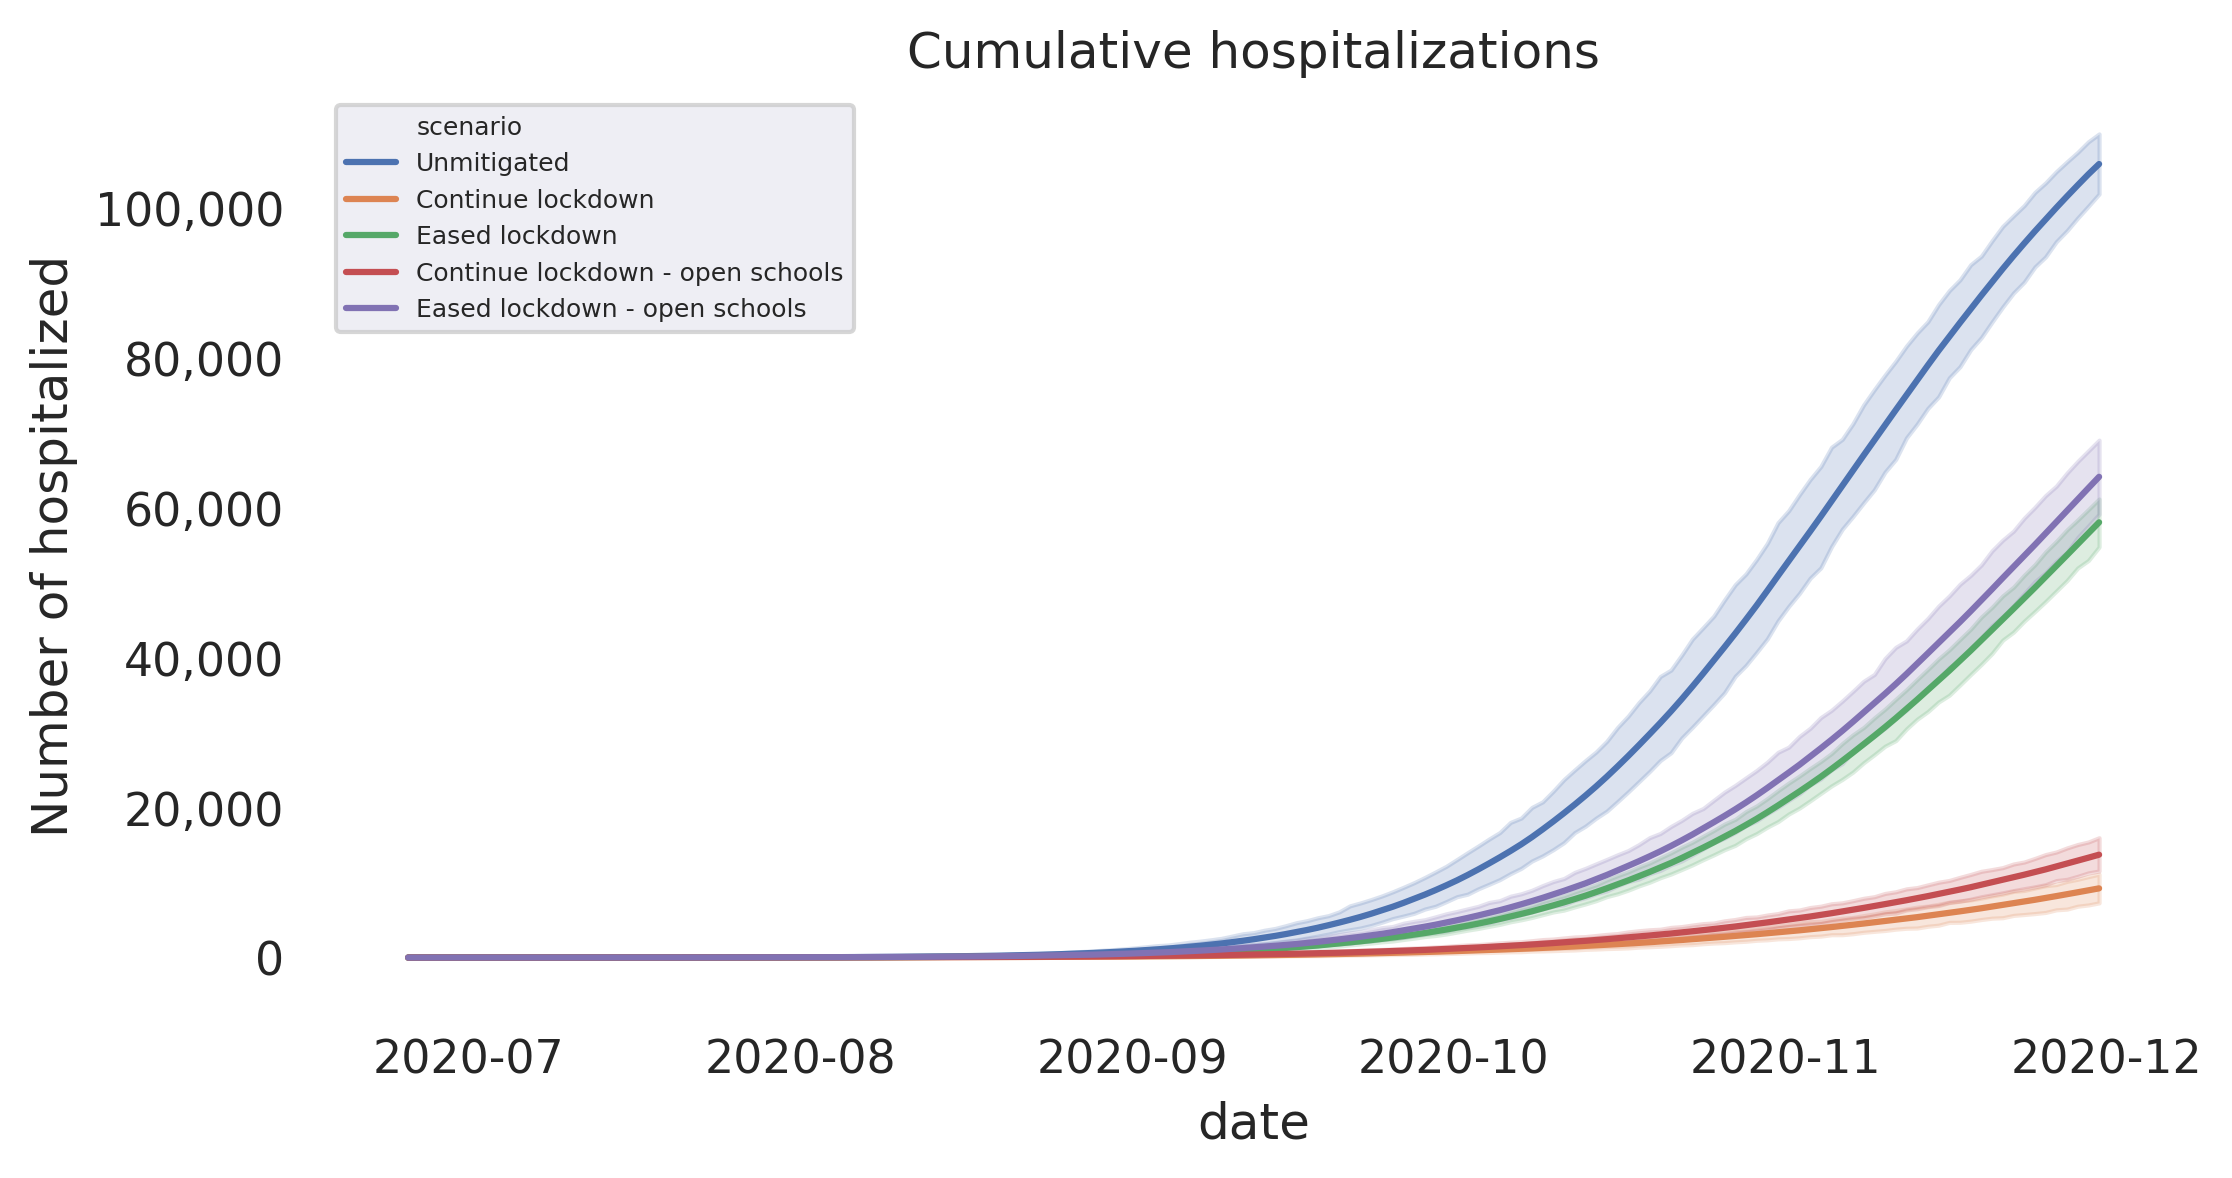

In [18]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Hospitalizations'] = scale * df['hospitalized_count']

sns.lineplot(x="date", y="Hospitalizations", hue='scenario',
             data=df, ax=ax)

ax.set_title('Cumulative hospitalizations')
ax.set_ylabel('Number of hospitalized')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

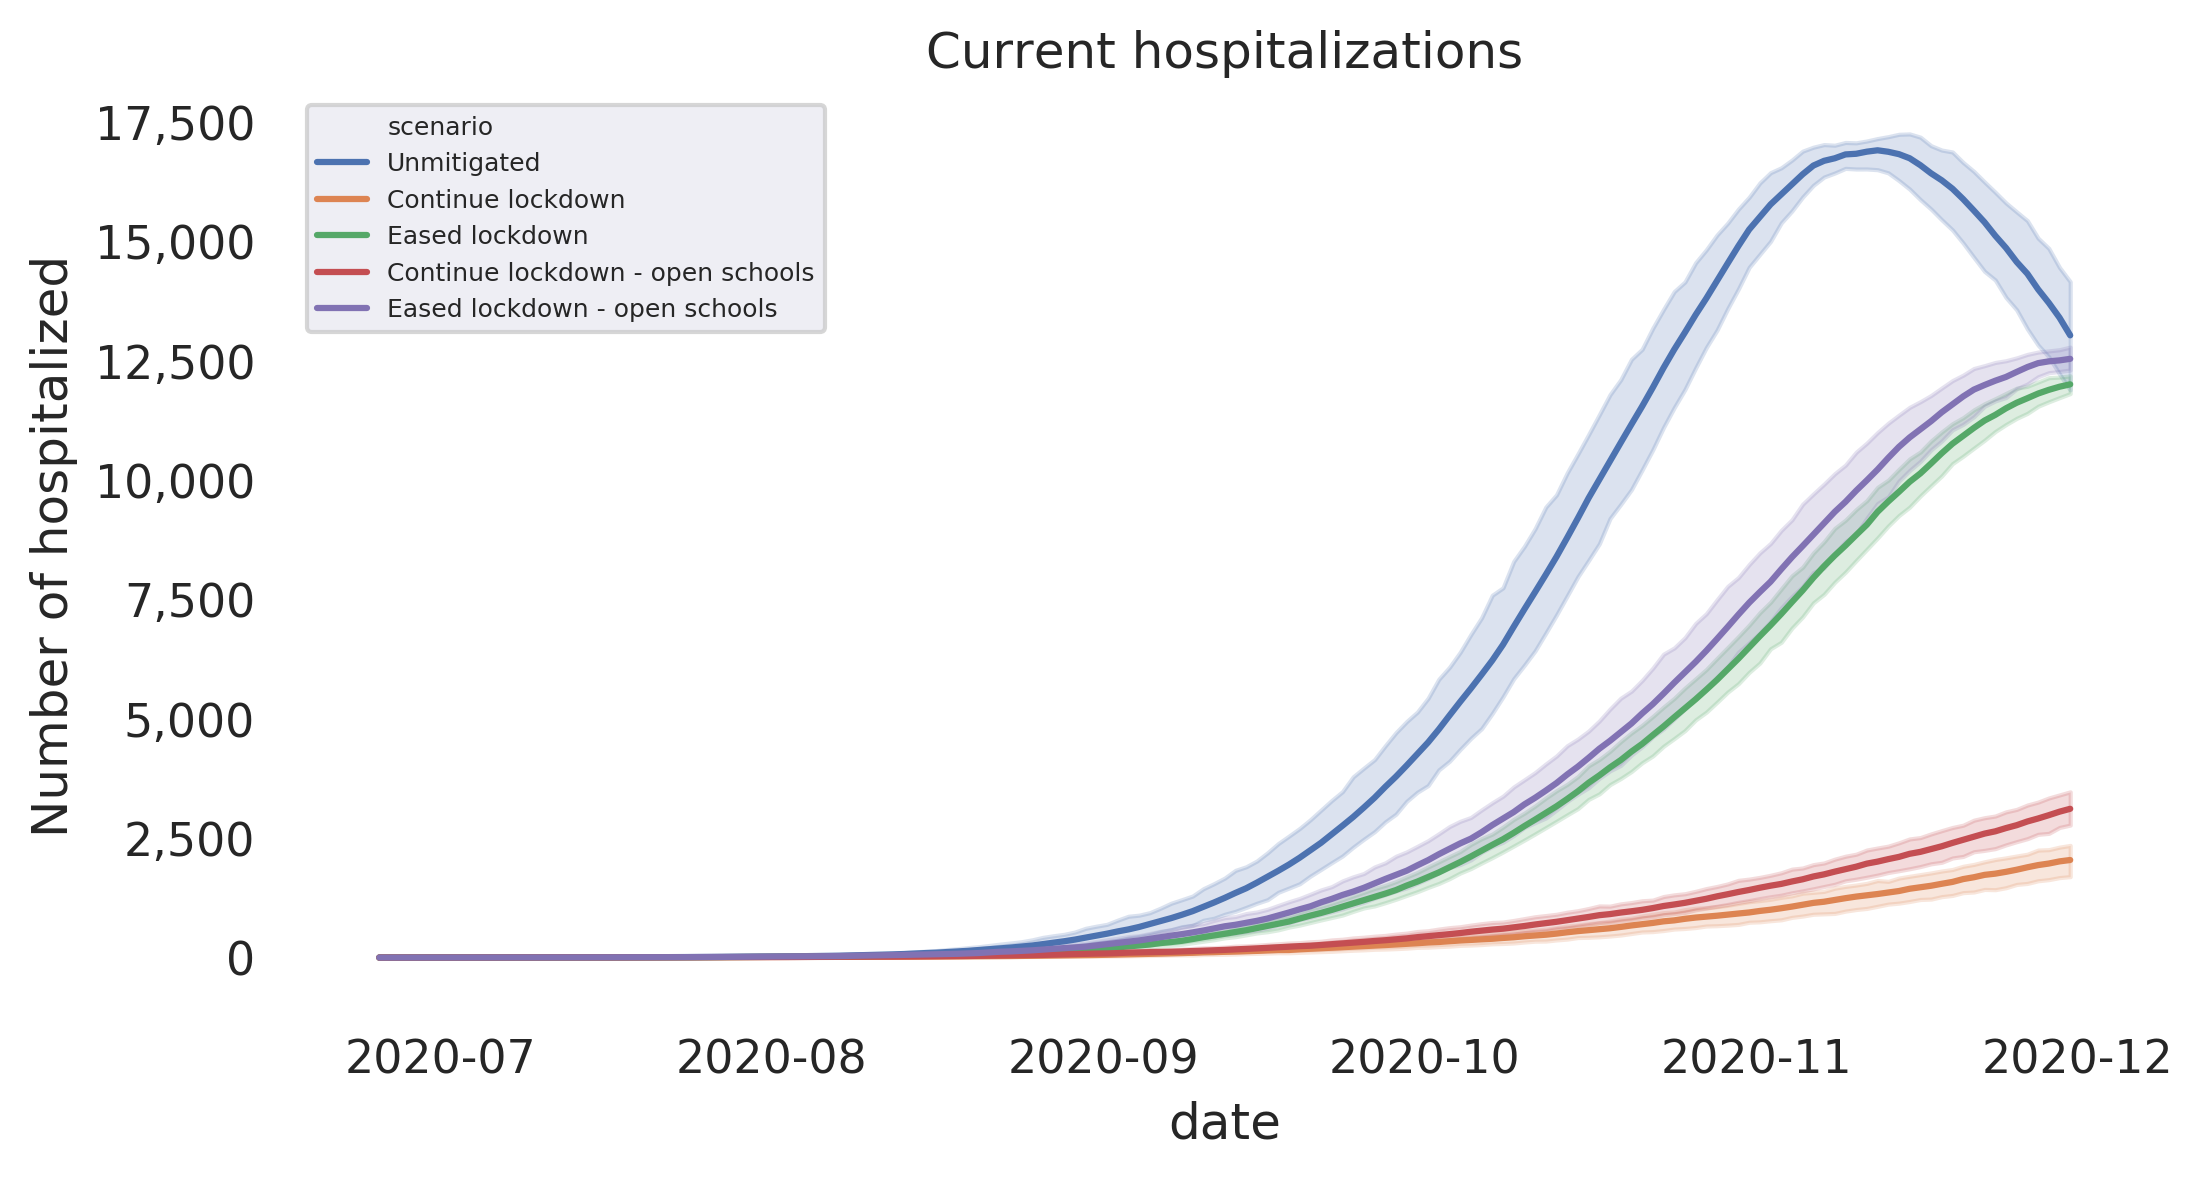

In [19]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Current hospitalizations'] = scale * df['current_hospitalized_cases']

sns.lineplot(x="date", y="Current hospitalizations", hue='scenario',
             data=df, ax=ax)

ax.set_title('Current hospitalizations')
ax.set_ylabel('Number of hospitalized')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

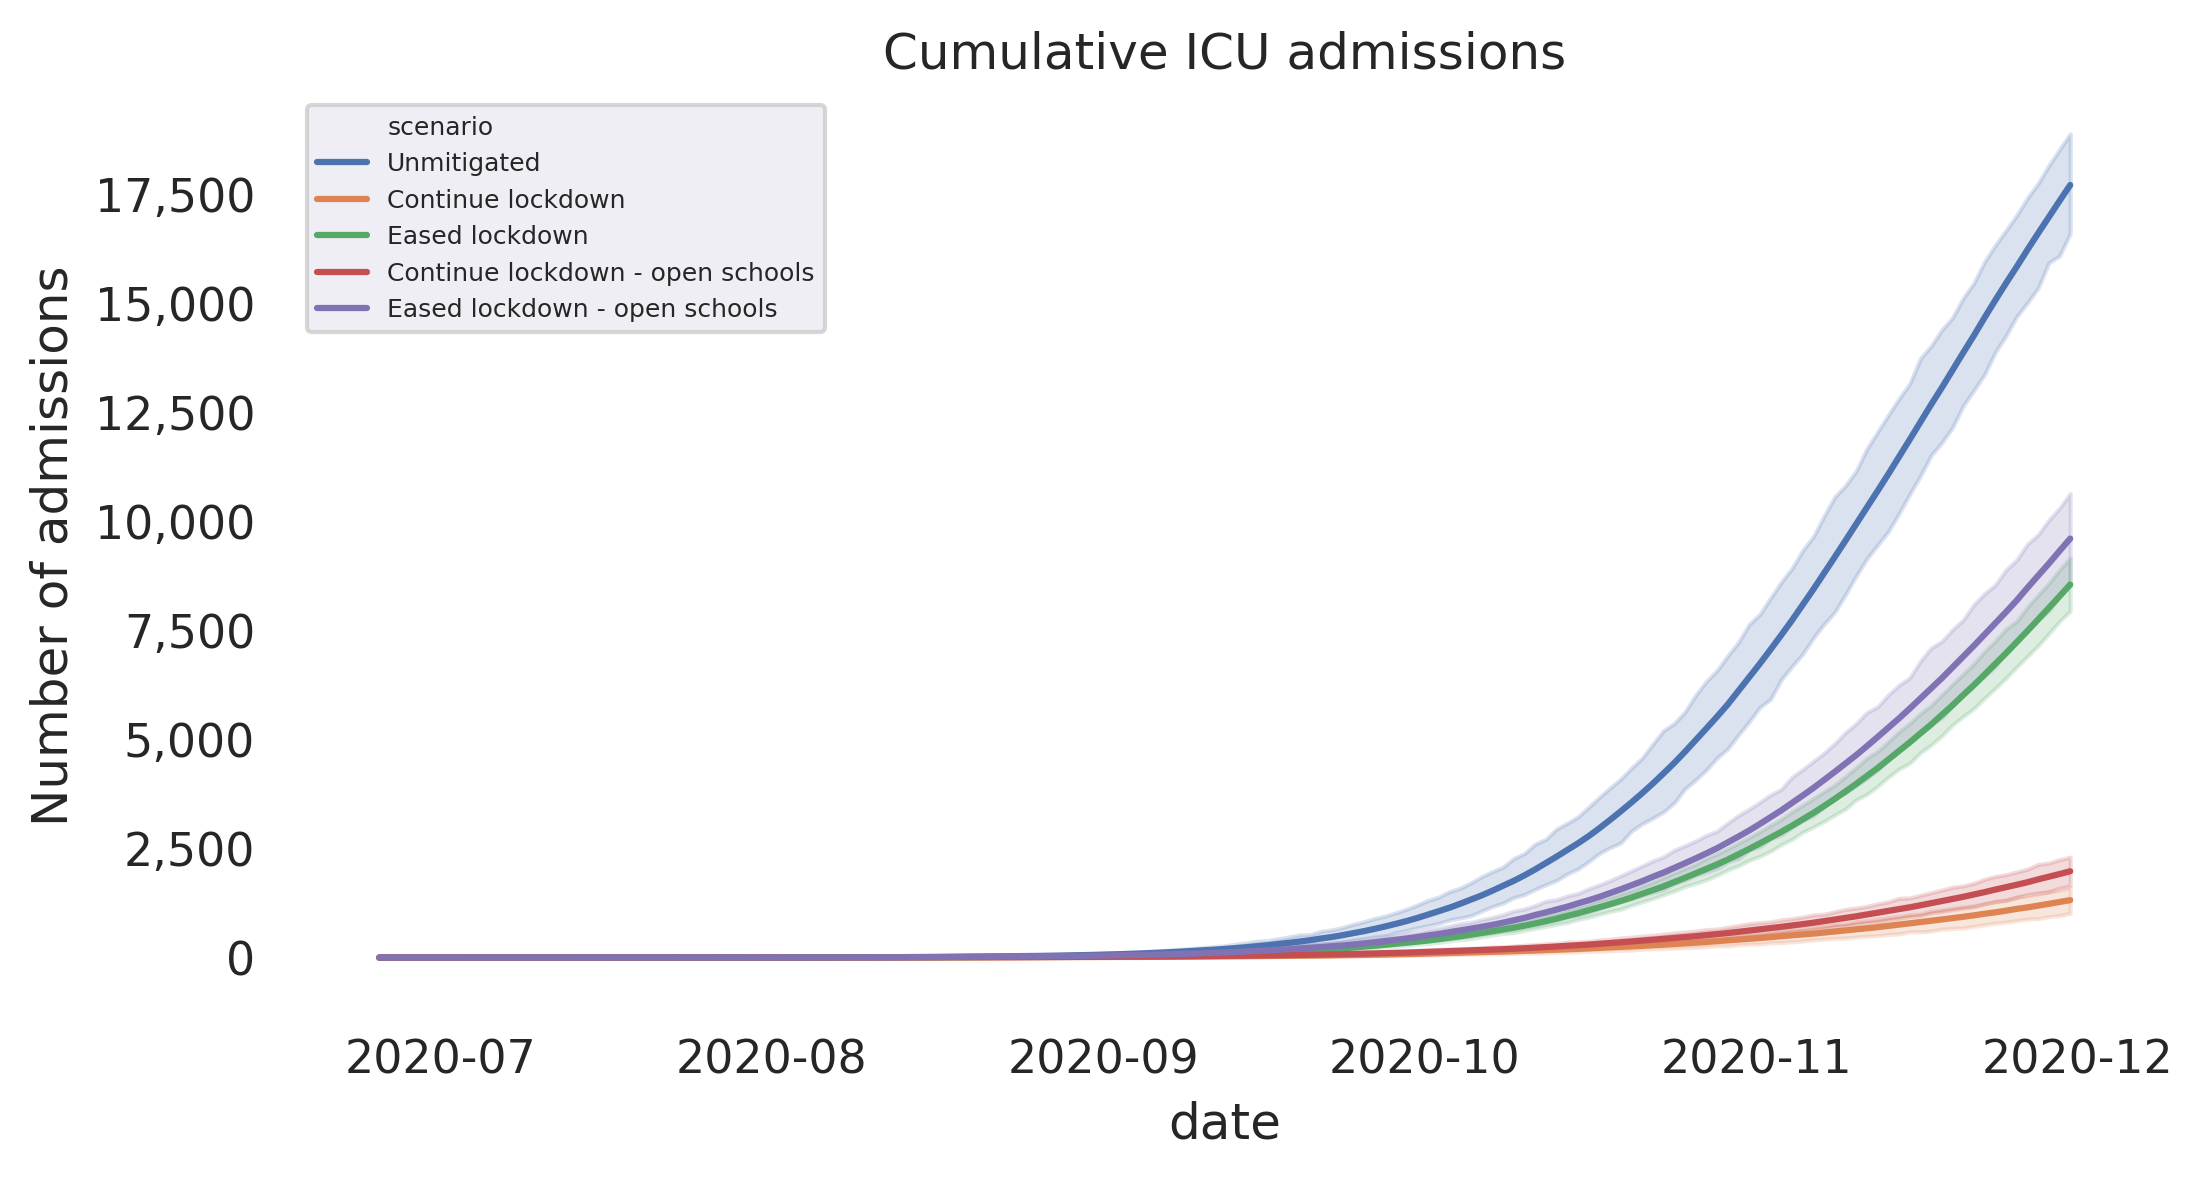

In [20]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['ICU admissions'] = scale * df['critical_count']

sns.lineplot(x="date", y="ICU admissions", hue='scenario',
             data=df, ax=ax)

ax.set_title('Cumulative ICU admissions')
ax.set_ylabel('Number of admissions')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

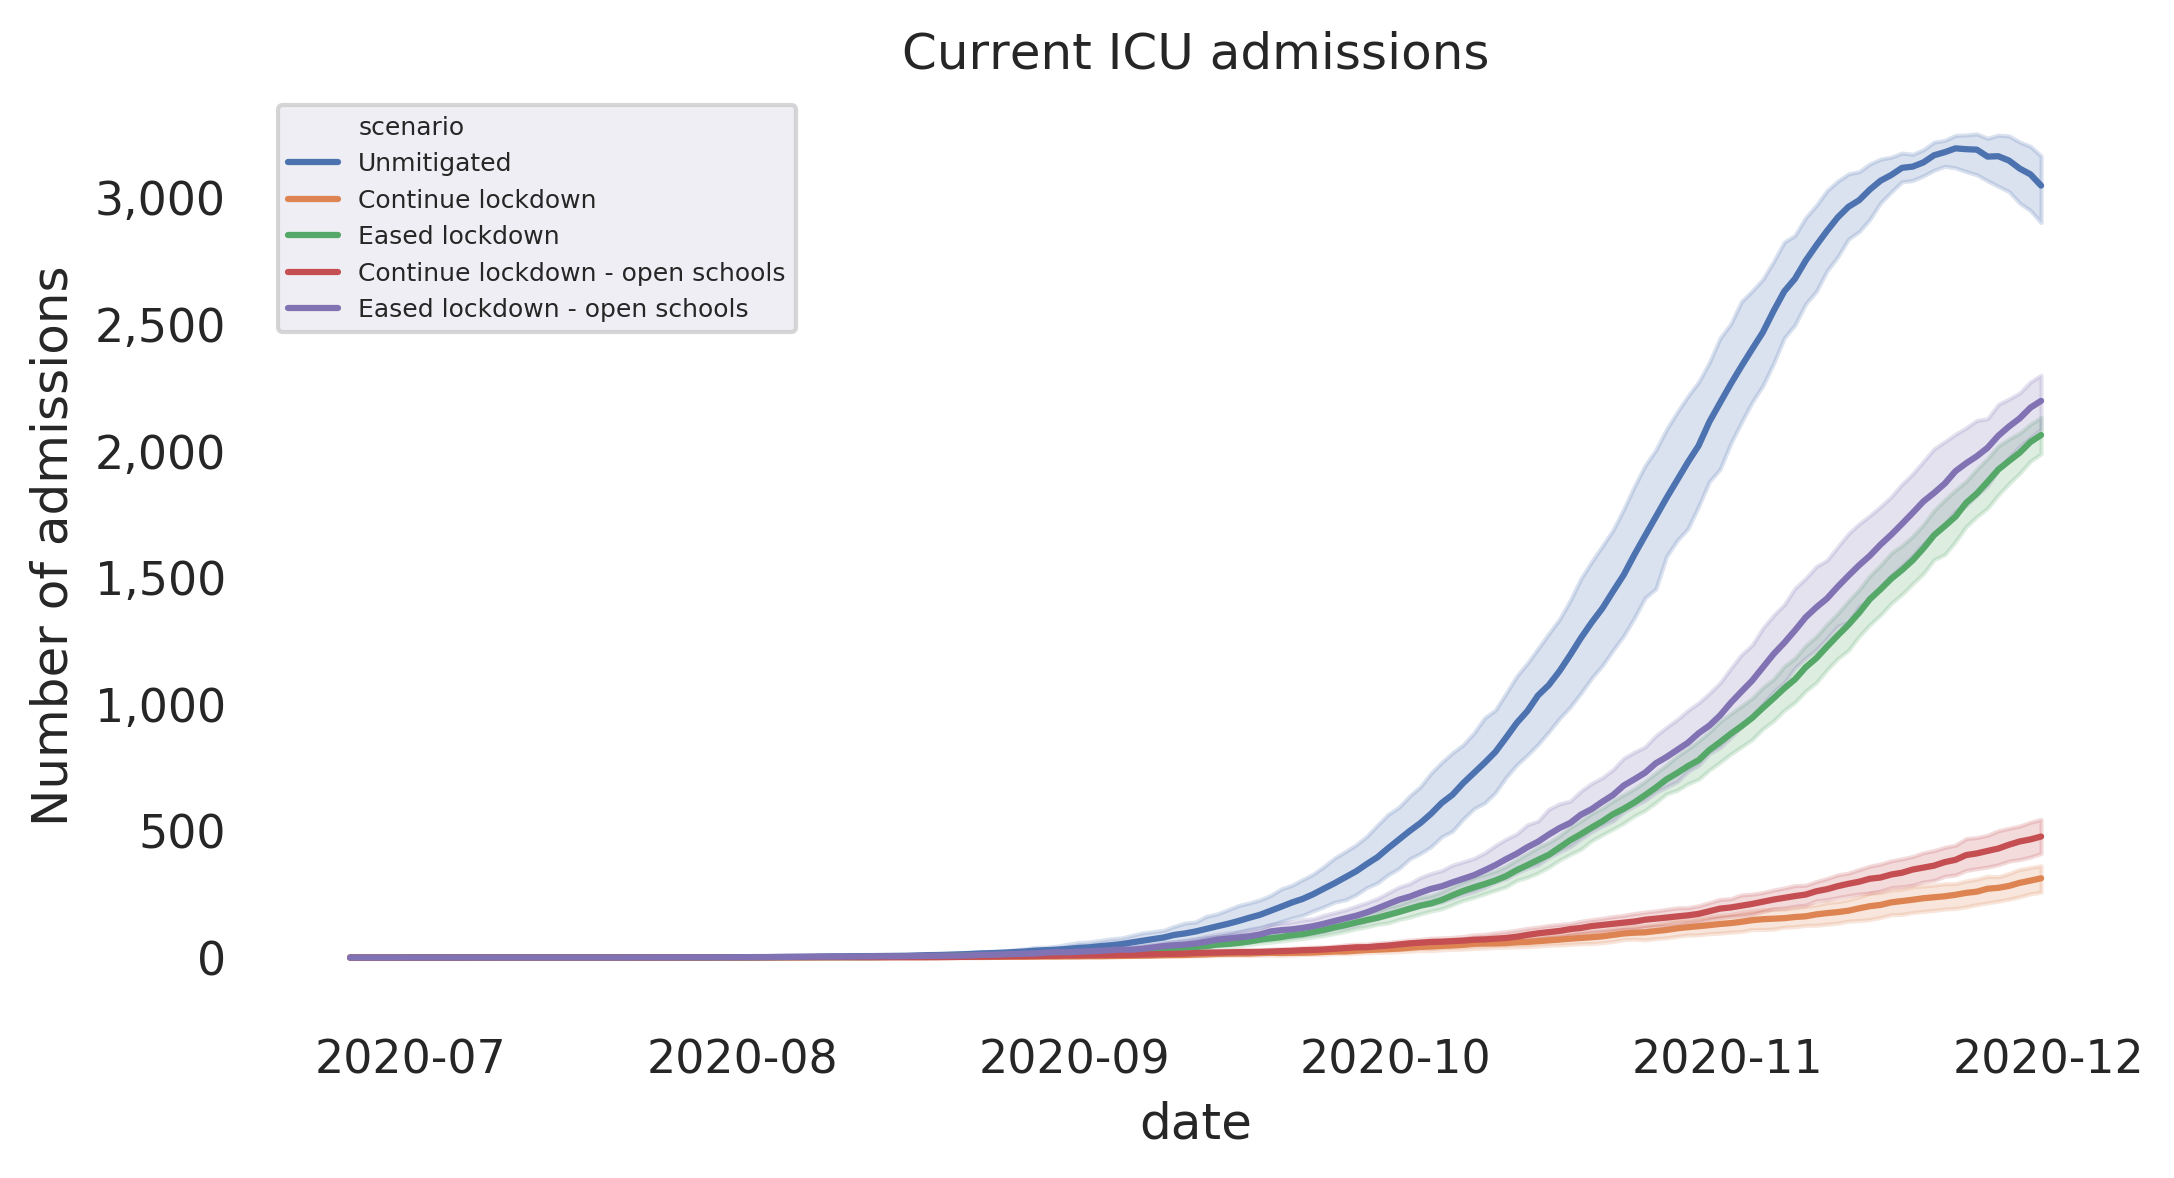

In [21]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot()

df['Current ICU admissions'] = scale * df['current_critical_cases']

sns.lineplot(x="date", y="Current ICU admissions", hue='scenario',
             data=df, ax=ax)

ax.set_title('Current ICU admissions')
ax.set_ylabel('Number of admissions')
ax.legend(fontsize=6, title_fontsize=6, loc='upper left')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)